In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from collections import OrderedDict
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.9.0


In [2]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        n_hidden = len(layers) 
        self.activation = nn.Tanh
        layer_list = []

        for i in range(n_hidden-2):

            linear = torch.nn.Linear(layers[i], layers[i+1])

            nn.init.xavier_normal_(linear.weight.data, gain=1.0)
            nn.init.zeros_(linear.bias.data)

            layer_list.append(
                ('layer_%d' % i, linear)
            )
            layer_list.append(
                ('activation_%d' % i, self.activation())
            )
        
        linear = torch.nn.Linear(layers[n_hidden-2], layers[n_hidden-1])
        nn.init.xavier_normal_(linear.weight.data, gain=1.0)
        nn.init.zeros_(linear.bias.data)

        layer_list.append(('layer_%d' % (n_hidden-2), linear))
        
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class PINN_Burgers:
    
    def __init__(self, net, x0, y0, x1, y1, lb, ub, dt, q, device):
        
        # data
        self.x0 = x0; self.x1 = x1; 
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
    
        self.y0 = torch.tensor(y0).float().to(device)
        self.y1 = torch.tensor(y1).float().to(device) 

        # net
        self.net = net.to(device)
        
        # unit time
        self.dt = torch.tensor(dt).to(device)
        # parameters
        tmp = np.float32(np.loadtxt('./Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        weights =  np.reshape(tmp[0:q**2+q], (q+1,q))     
        self.IRK_alpha = torch.from_numpy(weights[0:-1,:]).to(device) # q x q
        self.IRK_beta = torch.from_numpy(weights[-1:,:]).to(device) # 1 x q

        

        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        self.net.register_parameter('lambda_1', self.lambda_1)
        self.net.register_parameter('lambda_2', self.lambda_2)

        # opt: using both Adam and LBFGS
        self.opt_LBFGS = optim.LBFGS(
            self.net.parameters(), 
            lr=1., 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.iter = 0
        self.opt_Adam = optim.Adam(self.net.parameters(), lr=0.003)

        self.q = q
        self.device = device

    def neural_net(self, x):
        x = 2*(x-self.lb)/(self.ub-self.lb) - 1
        u = self.net(x)
        return u

    def create_dummy(self, x):
        return torch.ones((x.shape[0], self.q), requires_grad=True).to(self.device)

    def net_U0(self, x, dummy_x):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)

        u = self.neural_net(x)
        # very important! u is a matrix (stacked vector), we need jocobian J 

        # for single input x 
        # with x.shape = 1x1, net_output.shape = 1xq, J.shape = 1xq

        # calculation in torch:
        #  g_u = du/dx @ dummy = J @ dummy with shape 1xq @ qx1 = 1x1
        g_u = torch.autograd.grad(u, x, dummy_x, 
                                    retain_graph=True,
                                    create_graph=True)[0]
        
        # dg_u/ddummy @ torch.ones_like(g_u) = du/dx with shape 1xq

        u_x = torch.autograd.grad(g_u, dummy_x, torch.ones_like(g_u),
                                  retain_graph=True,
                                  create_graph=True)[0]

        # Note that we did bach-level computation: g_u will have shape nx1 (should be nx1x1 logically)
        assert g_u.shape == (x.shape[0],1)
        assert u_x.shape == (x.shape[0], self.q)

        # same here
        g_u_x = torch.autograd.grad(u_x, x, dummy_x,
                                    retain_graph=True,
                                    create_graph=True)[0]

        u_xx = torch.autograd.grad(g_u_x, dummy_x, torch.ones_like(g_u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
                                    
        assert g_u_x.shape == (x.shape[0],1)
        assert u_xx.shape == (x.shape[0], self.q)
        

        F = -lambda_1*u*u_x + lambda_2*u_xx
        u0 = u - self.dt*(F@self.IRK_alpha.T)
        return u0

    def net_U1(self, x, dummy_x):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)

        u = self.neural_net(x)
        g_u = torch.autograd.grad(u, x, dummy_x, 
                                    retain_graph=True,
                                    create_graph=True)[0]
        
        u_x = torch.autograd.grad(g_u, dummy_x, torch.ones_like(g_u),
                                  retain_graph=True,
                                  create_graph=True)[0]

        assert g_u.shape == (x.shape[0],1)
        assert u_x.shape == (x.shape[0], self.q)

        g_u_x = torch.autograd.grad(u_x, x, dummy_x,
                                    retain_graph=True,
                                    create_graph=True)[0]

        u_xx = torch.autograd.grad(g_u_x, dummy_x, torch.ones_like(g_u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
      
        assert g_u_x.shape == (x.shape[0],1)
        assert u_xx.shape == (x.shape[0], self.q)

        F = -lambda_1*u*u_x + lambda_2*u_xx
        u1 = u + self.dt*(F@(self.IRK_beta - self.IRK_alpha).T)
        return u1

    def _train_step(self):
        
        x0 = torch.tensor(self.x0, requires_grad=True).float().to(device)
        x1 = torch.tensor(self.x1, requires_grad=True).float().to(device)
        dummy_x0 = self.create_dummy(x0)
        dummy_x1 = self.create_dummy(x1)
        u0_pred = self.net_U0(x0, dummy_x0)
        u1_pred = self.net_U1(x1, dummy_x1)
        loss = torch.sum((self.y0-u0_pred)**2)  + torch.sum((self.y1-u1_pred)**2)

        return loss

    def _closure(self):
        loss = self._train_step()
        self.opt_LBFGS.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 200 == 0:
            print('epoch: {}  loss: {:.4f}  lam_1: {:4f}  lam_2: {:.4f}'.format(self.iter, 
                                                                                loss.item(),
                                                                                self.lambda_1.item(),
                                                                                torch.exp(self.lambda_2).item()))
        return loss

    def train(self, epochs):
        self.net.train() # training mode
        for epoch in range(epochs):
            
            loss = self._train_step() 
            
            self.opt_Adam.zero_grad()
            loss.backward()
            self.opt_Adam.step()

            if (epoch+1) % 200 == 0:
                print('epoch: {}  loss: {:.4f}  lam_1: {:4f}  lam_2: {:.4f}'.format(epoch+1, 
                                                                                    loss.item(),
                                                                                    self.lambda_1.item(),
                                                                                    torch.exp(self.lambda_2).item()))
        self.opt_LBFGS.step(self._closure)

    def predict(self, x):
        x = torch.tensor(x, requires_grad=True).float().to(device)
        dummy_x = self.create_dummy(x)
        self.net.eval()
        u0_pred = self.net_U0(x, dummy_x)
        u1_pred = self.net_U1(x, dummy_x)
        return u0_pred.detach().cpu().numpy(), u1_pred.detach().cpu().numpy()


In [4]:
skip = 80

N0 = 199 + 20
N1 = 201 + 30

import scipy.io
data = scipy.io.loadmat('./Data/burgers_shock.mat')

t_star = data['t'].flatten()[:,None]
x_star = data['x'].flatten()[:,None]
Exact = np.real(data['usol'])

idx_t = 10

# Domain bounds
lb = x_star.min(0)
ub = x_star.max(0)

In [5]:
noise = 0.0    
    
idx_x = np.random.choice(Exact.shape[0], N0, replace=False)
x0 = x_star[idx_x,:]
u0 = Exact[idx_x,idx_t][:,None]
u0 = u0 + noise*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
    
idx_x = np.random.choice(Exact.shape[0], N1, replace=False)
x1 = x_star[idx_x,:]
u1 = Exact[idx_x,idx_t + skip][:,None]
u1 = u1 + noise*np.std(u1)*np.random.randn(u1.shape[0], u1.shape[1])

dt = (t_star[idx_t+skip] - t_star[idx_t])        
q = int(np.ceil(0.5*np.log(np.finfo(float).eps)/np.log(dt)))

layers = [1, 50, 50, 50, 50, q]

In [6]:
net = DNN(layers)
net

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=1, out_features=50, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=50, out_features=50, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=50, out_features=81, bias=True)
  )
)

In [7]:
pinn = PINN_Burgers(net, x0, u0, x1, u1, lb, ub, dt, q, device)
pinn.train(epochs=1000)

epoch: 200  loss: 703.1437  lam_1: 0.339854  lam_2: 0.0026
epoch: 400  loss: 148.3475  lam_1: 0.650857  lam_2: 0.0055
epoch: 600  loss: 33.2989  lam_1: 0.830003  lam_2: 0.0066
epoch: 800  loss: 14.9513  lam_1: 0.898525  lam_2: 0.0066
epoch: 1000  loss: 8.6020  lam_1: 0.931920  lam_2: 0.0065
epoch: 200  loss: 2.1070  lam_1: 0.981928  lam_2: 0.0049
epoch: 400  loss: 0.9426  lam_1: 0.989272  lam_2: 0.0043
epoch: 600  loss: 0.4712  lam_1: 0.994945  lam_2: 0.0039
epoch: 800  loss: 0.3085  lam_1: 0.997601  lam_2: 0.0038
epoch: 1000  loss: 0.2169  lam_1: 0.998115  lam_2: 0.0036
epoch: 1200  loss: 0.1636  lam_1: 0.998068  lam_2: 0.0035
epoch: 1400  loss: 0.1251  lam_1: 0.998232  lam_2: 0.0035
epoch: 1600  loss: 0.0952  lam_1: 0.998729  lam_2: 0.0034
epoch: 1800  loss: 0.0718  lam_1: 0.999186  lam_2: 0.0033
epoch: 2000  loss: 0.0577  lam_1: 0.999320  lam_2: 0.0033
epoch: 2200  loss: 0.0484  lam_1: 0.999498  lam_2: 0.0033
epoch: 2400  loss: 0.0402  lam_1: 0.999556  lam_2: 0.0033
epoch: 2600  los

In [8]:
nu = 0.01/np.pi
error_lambda_1 = np.abs(pinn.lambda_1.detach().cpu().numpy() - 1.0)/1*100
error_lambda_2 = np.abs(np.exp(pinn.lambda_2.detach().cpu().numpy()) - nu)/nu * 100
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))

Error l1: 0.00026%
Error l2: 0.04771%


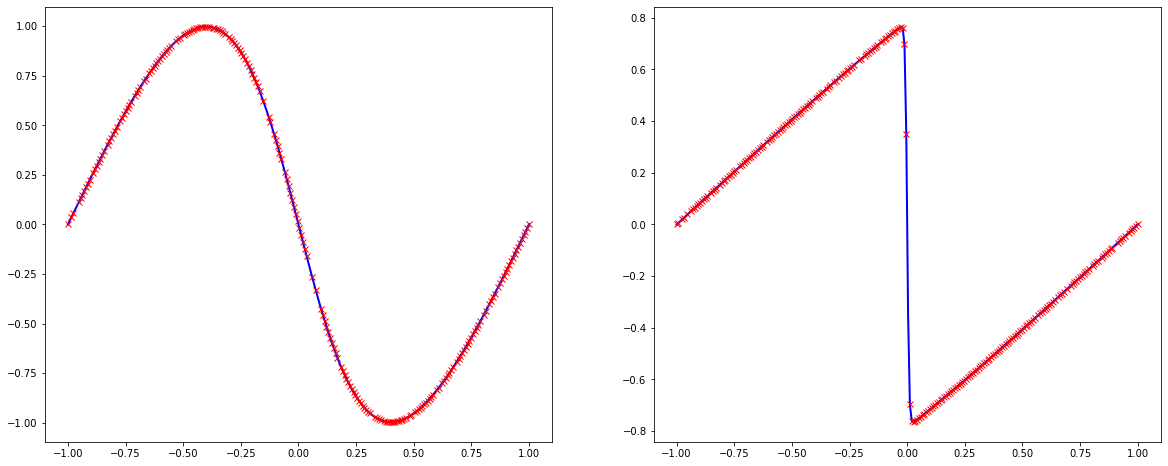

In [11]:
u0_pred, u1_pred = pinn.predict(x_star)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(x_star, u0_pred[:,0], 'b-', linewidth = 2, label = 'Exact')
axs[0].plot(x0, u0, 'rx')

axs[1].plot(x_star, u1_pred[:,0], 'b-', linewidth = 2, label = 'Exact')
axs[1].plot(x1, u1, 'rx')